In [125]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import seaborn as sns

from torchvision import transforms

from IPython.display import clear_output

from sklearn.metrics import classification_report, accuracy_score, f1_score

In [126]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

!nvidia-smi

CUDA is available!  Training on GPU ...
cuda
Mon Dec 19 21:39:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    29W /  70W |    836MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                           

### Подготовка данных для использования
 - Получение Датасета
 - Получение Даталоадера
 - Просмотр данных

In [127]:
train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform=ToTensor()
)
test_dataset = datasets.MNIST(
    root = './data',
    train = False,
    transform=ToTensor()
)

In [128]:
BATCH_SIZE = 64

In [129]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [130]:
### Целевое значение
next(iter(train_dataloader))[1]

tensor([1, 7, 5, 9, 2, 1, 8, 8, 5, 0, 2, 4, 5, 5, 8, 4, 4, 1, 8, 6, 2, 6, 2, 8,
        2, 7, 8, 5, 8, 2, 2, 4, 3, 3, 7, 1, 4, 6, 7, 0, 2, 2, 4, 9, 2, 4, 3, 2,
        7, 9, 2, 4, 2, 1, 6, 0, 5, 2, 1, 3, 5, 3, 2, 3])

In [131]:
### Torch tensor
next(iter(train_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

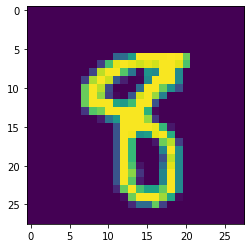

In [132]:
for_show = next(iter(train_dataloader))[0]
plt.imshow(for_show.numpy()[0][0])

### Построим нейронную сеть, чтобы для решения задачи бинарной классфикации (является ли цифра 9-кой или нет)

In [133]:
class IsOne(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.Linear1 = torch.nn.Linear(28*28, 256)
        self.Linear2 = torch.nn.Linear(256, 64)
        self.Linear3 = torch.nn.Linear(64, 1)
        self.relu = torch.nn.ReLU()
        self.Sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        x = x.squeeze(1)
        x = x.flatten(1)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        x = self.relu(x)
        x = self.Linear3(x).squeeze(1)
        x = self.Sigmoid(x)
        return x

In [134]:
model = IsOne().to(device)

### Функция, вычисляющая лосс

In [135]:
def loss_function(true, pred):
    loss = torch.nn.BCELoss()
    return loss(pred, true)

### Оптимизатор

In [136]:
optimizer = torch.optim.SGD(params = model.parameters(), lr = 1e-3)

### Построим процесс обучения нейронной сети

In [137]:
NUM_EPOCHS = 10
WANTED_LABEL = 9

In [181]:
train_loss = []
test_loss = []
for epoch in tqdm(range(NUM_EPOCHS)):
    model.train(True)
    train_loss_epoch = 0
    test_loss_epoch = 0
    for X, y in train_dataloader:
        model.zero_grad()
        true = (y == WANTED_LABEL).float().to(device)
        predictions = model.forward(X.to(device))
        loss_value = loss_function(true, predictions)
        loss_value.backward()
        train_loss_epoch += loss_value.item()/len(train_dataloader)
        optimizer.step()
        
    train_loss.append(train_loss_epoch)
    #print(train_loss)
    model.train(False)
    for X, y in test_dataloader:
        true = (y == WANTED_LABEL).float().to(device)
        predictions = model.forward(X.to(device))
        loss_value = loss_function(true, predictions)
        test_loss_epoch += loss_value.item()/len(test_dataloader)
    test_loss.append(test_loss_epoch)
    # print(epoch, train_loss[-1], test_loss[-1])


  0%|          | 0/10 [00:00<?, ?it/s]

[0.19304766672938717]


 10%|█         | 1/10 [00:07<01:03,  7.08s/it]

[0.19304766672938717, 0.18692342746156002]


 20%|██        | 2/10 [00:19<01:24, 10.51s/it]

[0.19304766672938717, 0.18692342746156002, 0.18145536181289343]


 30%|███       | 3/10 [00:30<01:12, 10.34s/it]

[0.19304766672938717, 0.18692342746156002, 0.18145536181289343, 0.17639060194426198]


 40%|████      | 4/10 [00:37<00:54,  9.01s/it]

[0.19304766672938717, 0.18692342746156002, 0.18145536181289343, 0.17639060194426198, 0.1717591490974232]


 50%|█████     | 5/10 [00:44<00:41,  8.34s/it]

[0.19304766672938717, 0.18692342746156002, 0.18145536181289343, 0.17639060194426198, 0.1717591490974232, 0.1672090240132974]


 60%|██████    | 6/10 [00:51<00:32,  8.07s/it]

[0.19304766672938717, 0.18692342746156002, 0.18145536181289343, 0.17639060194426198, 0.1717591490974232, 0.1672090240132974, 0.16309855573809645]


 70%|███████   | 7/10 [01:03<00:28,  9.40s/it]

[0.19304766672938717, 0.18692342746156002, 0.18145536181289343, 0.17639060194426198, 0.1717591490974232, 0.1672090240132974, 0.16309855573809645, 0.15908481086044712]


 80%|████████  | 8/10 [01:11<00:17,  8.80s/it]

[0.19304766672938717, 0.18692342746156002, 0.18145536181289343, 0.17639060194426198, 0.1717591490974232, 0.1672090240132974, 0.16309855573809645, 0.15908481086044712, 0.1549418320603024]


 90%|█████████ | 9/10 [01:18<00:08,  8.24s/it]

[0.19304766672938717, 0.18692342746156002, 0.18145536181289343, 0.17639060194426198, 0.1717591490974232, 0.1672090240132974, 0.16309855573809645, 0.15908481086044712, 0.1549418320603024, 0.15127156285634674]


100%|██████████| 10/10 [01:25<00:00,  8.54s/it]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


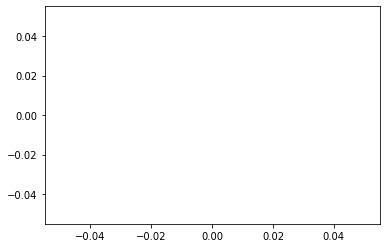

In [182]:
sns.lineplot(train_loss)
sns.lineplot(test_loss)

In [183]:
preds = []
reals = []

with torch.no_grad():
  for X, y in test_dataloader:
      preds.append(model(X.to(device)).detach().cpu().numpy())
      reals.append((y==WANTED_LABEL).int().to(device).cpu().numpy())

In [184]:
preds = (np.concatenate(preds)>=0.5).astype(int)
reals = np.concatenate(reals)

In [186]:
accuracy_score(preds, reals), f1_score(reals, preds)

(0.9483173076923077, 0.6636245110821382)

In [187]:
print(classification_report(reals, preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8976
           1       0.97      0.50      0.66      1008

    accuracy                           0.95      9984
   macro avg       0.96      0.75      0.82      9984
weighted avg       0.95      0.95      0.94      9984



### Домашняя работа
Изменить нейронную сеть следующим образом:
 - Чтобы она решала задачу не бинарной классификации, а многоклассовой (Для этого нужно использовать другую лосс функцию и функцию активации на выходе)
 - Чтобы в ней было не 2 скрытых слоя, а три
 - Чтобы кол-во нейронов подставлялось через массив, поданный при инициализации класса модели
 - Чтобы происходил dropout (вероятность 0.3) до первого скрытого слоя. Показать, как это изменение повлияло на результат работы модели на тестовой выборке.
 - Посчитать метрики классификации через classification report (sklearn) для каждого класса

### Построим нейронную сеть, чтобы для решения задачи мультиклассовой классфикации 

In [190]:
batch_size = 64
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [259]:
num_features = 10

In [260]:
class Multy(torch.nn.Module):
    def __init__(self):
        super().__init__()

                 
        self.seq = torch.nn.Sequential(
            torch.nn.Linear(28*28, 512), 
            torch.nn.Dropout(p=0.3),
            torch.nn.ReLU(),                       
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, num_features),
            torch.nn.ReLU(),
            torch.nn.Softmax(dim = 1)
        )

    def forward(self, x):
        x = x.squeeze(1)
        x = x.flatten(1)
        x = self.seq(x)
        return x

### Параметры

In [261]:
NUM_EPOCHS = 50
criterion = torch.nn.CrossEntropyLoss()
model = Multy().to(device)
optimizer = torch.optim.Adam(model.parameters())

### Построим процесс обучения нейронной сети

In [262]:
model

Multy(
  (seq): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=64, bias=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=10, bias=True)
    (10): ReLU()
    (11): Softmax(dim=1)
  )
)

In [263]:
def train(model, optimizer, epochs=NUM_EPOCHS, learning_rate=lr):  
  train_loss = []
  val_loss = []
  pred = []
  val_acc = []

  for epoch in tqdm(range(epochs)):
      model.train()
      train_loss_epoch = 0
      val_loss_epoch = 0
      for X, y in train_dataloader:
          model.zero_grad()
          features = X.to(device)
          target = y.to(device)
          predictions = model(features)
          loss = criterion(predictions, target)
          loss.backward()
          train_loss_epoch += loss.item()/len(train_dataloader)
          optimizer.step()
      train_loss.append(train_loss_epoch)

      preds = []
      targets = []
      model.eval()
      for X, y in test_dataloader:
          features = X.to(device)
          target = y.to(device)
          predictions = model(features)
          loss = criterion(predictions, target)
          val_loss_epoch += loss.item()/len(test_dataloader)
          preds.append(predictions.argmax(axis = 1).detach().cpu().numpy())
          targets.append(target.cpu().numpy())

      val_loss.append(val_loss_epoch)
      val_acc.append(f1_score(np.concatenate(targets), np.concatenate(preds), average = 'micro'))

      fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
      clear_output(True)
      if train_loss is not None:
          ax.plot(train_loss, label='general train history')
          ax.set_xlabel('Epoch')
          ax.set_title('Train and Val loss')
      if val_loss is not None:
          ax.plot(val_loss, label='general valid history')
      plt.legend()
      plt.show()  

      print(f'\nEpoch: {epoch+1:01}')
      print(f'Train Loss: {train_loss[epoch]:.3f}')
      print(f' Val. Loss: {val_loss[epoch]:.3f} | Val.F_1: {val_acc[epoch]:.3f}')

  return train_loss, val_loss, val_acc

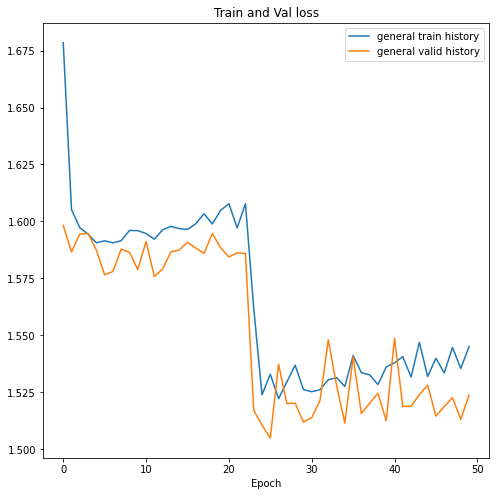

100%|██████████| 50/50 [07:07<00:00,  8.55s/it]


Epoch: 50
Train Loss: 1.545
 Val. Loss: 1.524 | Val.F_1: 0.937


In [264]:
train_history, val_history, val_acc = train(model, optimizer=optimizer)

Сохраним веса получившейся модели. 

In [270]:
torch.save(model.state_dict(), 'HW-model.pt')

In [265]:
preds = []
reals = []
for X, y in test_dataloader:
    preds.append(model(X.to(device)).detach().cpu().numpy())
    reals.append(y.to(device).int().cpu().numpy())

In [266]:
preds[0].argmax(axis = 1)

array([7, 0, 6, 4, 9, 5, 1, 2, 9, 9, 7, 1, 9, 0, 4, 1, 6, 0, 6, 9, 4, 8,
       5, 2, 6, 2, 6, 0, 6, 3, 8, 8, 8, 2, 1, 9, 2, 0, 3, 0, 5, 1, 5, 7,
       3, 2, 1, 4, 3, 3, 3, 5, 5, 9, 7, 6, 7, 6, 8, 5, 6, 9, 4, 2])

In [267]:
preds = (np.concatenate(preds).argmax(axis = 1)).astype(int)
len(preds)

9984

In [268]:
reals = np.concatenate(reals)
len(reals)

9984

In [269]:
print(classification_report(reals,preds))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       974
           1       0.96      0.98      0.97      1132
           2       0.93      0.95      0.94      1031
           3       0.93      0.93      0.93      1008
           4       0.89      0.96      0.92       981
           5       0.98      0.88      0.93       891
           6       0.89      0.98      0.93       957
           7       0.96      0.93      0.95      1028
           8       0.95      0.92      0.94       974
           9       0.94      0.88      0.91      1008

    accuracy                           0.94      9984
   macro avg       0.94      0.94      0.94      9984
weighted avg       0.94      0.94      0.94      9984



### Вывод:
1. Модель обучалась 50 эпох и достигла неплохих показателей, на мой взгляд. F-1 = 0.94. 
2. Использовились лосс-функция CrossEntropyLoss() и оптимизатор Adam с дефолтными параметрами. 
3. На 24 эпохе loss значительно упал, и по графику видно, что 27 эпох в целом было бы достаточно. 
4. Dropout = 0.3 дает значительное уменьшение lossa (и соответственно, прирост в метрике) по сравнению с Dropout = 0.1. Проверено эмпирическим путем.
